# __Research Question:__

What set of criteria is most important to the sucess of a mutual fund? What about amongst ETFs? Which type of fund is more successful overall can can the success of a fund be accurately predicted based on these observed criteria?

### Importing:

In [1]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

### Data overview:

The file contains 24,821 Mutual Funds and 1,680 ETFs with general aspects (as Total Net Assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as yeartodate, 2020-11) and financial ratios (as price/earning, Treynor and Sharpe ratios, alpha, and beta). This data was scraped from Yahoo Finance by kaggle user Stefano Leone.

Link to dataset: https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs


In [2]:

df_mf=pd.read_csv('USData/Mutual Funds.csv')
df_etf=pd.read_csv('USData/ETFs.csv')


C:\Users\camro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (167,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_mf.describe()

,rating,return_rating,risk_rating,fund_net_annual_expense_ratio,category_net_annual_expense_ratio,asset_cash,asset_stocks,asset_bonds,asset_others,asset_preferred,...,fund_sharpe_ratio_3years,category_sharpe_ratio_3years,fund_sharpe_ratio_5years,category_sharpe_ratio_5years,fund_sharpe_ratio_10years,category_sharpe_ratio_10years,category_treynor_ratio_3years,fund_treynor_ratio_5years,category_treynor_ratio_5years,category_treynor_ratio_10years
count,23781.000000,23749.000000,23781.000000,24821.000000,24811.000000,24794.000000,24794.000000,24794.000000,24794.000000,24794.000000,...,23917.000000,24811.000000,22325.000000,24811.000000,17294.000000,24811.000000,24811.000000,22325.000000,24811.00000,24811.000000
mean,3.032126,3.024296,3.076363,1.090285,0.990609,7.597808,59.115730,30.176523,1.224323,0.324007,...,0.289693,0.002004,0.460688,0.004986,0.620369,0.006797,0.031430,4.983402,0.05205,0.058781
std,1.102552,1.101567,1.106091,0.850758,0.323830,13.502829,42.636769,38.425692,5.409480,2.279751,...,0.390553,0.004128,0.318069,0.005045,0.299822,0.004714,0.101032,12.571352,0.04428,0.223018
min,1.000000,1.000000,1.000000,0.000000,0.390000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.510000,-0.010000,-2.960000,-0.010000,-4.360000,-0.010000,-0.170000,-830.200000,-0.30000,-2.560000
25%,2.000000,2.000000,2.000000,0.690000,0.800000,1.090000,0.310000,0.000000,0.000000,0.000000,...,0.060000,0.000000,0.280000,0.000000,0.470000,0.000000,0.000000,2.130000,0.03000,0.030000
50%,3.000000,3.000000,3.000000,0.990000,1.010000,2.990000,83.440000,1.270000,0.000000,0.000000,...,0.300000,0.000000,0.490000,0.010000,0.650000,0.010000,0.030000,4.230000,0.04000,0.060000
75%,4.000000,4.000000,4.000000,1.390000,1.160000,7.320000,98.090000,64.810000,0.060000,0.010000,...,0.520000,0.000000,0.660000,0.010000,0.810000,0.010000,0.040000,7.250000,0.07000,0.080000
max,5.000000,5.000000,5.000000,96.000000,2.370000,100.000000,100.000000,110.200000,100.000000,80.550000,...,3.430000,0.010000,1.700000,0.010000,2.660000,0.010000,0.970000,398.090000,0.23000,1.200000


# __DATA CLEANING APPENDIX__:


Throwing away  4 completely empty columns in df_etf - ['category_return_2019', 'category_return_2018', 'category_return_2017', 'category_return_2016']:

In [4]:
empty_cols2 = [col for col in df_etf.columns if df_etf[col].isnull().all()]
df_etf.drop(empty_cols2,
        axis=1,
        inplace=True)



Throwing away the unnecessary columns that don't contain information useful to our analysis in both df_mf and df_etf:

In [5]:
throwaway_cols=[
    'quarters_up',
    'quarters_down',
    'top10_holdings',
    'years_up',
    'years_down',
    'currency'
]
df_mf.drop(columns=throwaway_cols,axis=1,inplace=True)
df_etf.drop(columns=throwaway_cols[2:],axis=1,inplace=True)

df_etf.to_csv('USData/NoEmptiesETFs.csv',index=False)
df_mf.to_csv('USData/NoEmptiesMutual Funds.csv',index=False)


Creating a method that allows us to isolate sections of each data frame based on keywords in their column names:

In [7]:
### Creates and returns a subset of df_mf by keeping only the columns with 'keyword' in their column name. 
def cleanbykeyword(df,keyword):
    """
    Searches and creates a list of all of the column names in df that contain the keyword.
    Subsets the df according to this list, then creates a df_new dataframe with this 
    information and drops the corresponding columns from the original df.

    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
        
        
    Return: dataframe containing data matching keyword.
    """
    col_list=[ i for i in df.columns if (keyword in i)] 
    #print(col_list)
    df_new=df[col_list]
    df.drop(columns=col_list,axis=1,inplace=True) #removes duplicate data from df_mf masterframe
    df_new.insert(0,'fund_symbol',df.fund_symbol) #inserts the fund symbols as the 1st column of the new data set
    return (df_new)

Removing category data from the dataframe. Some of the category columns were not updated properly in the data set and therefore cannot be used in our analyses, we drop them to save space: 


In [8]:
df_mf_category_data=cleanbykeyword(df_mf,'category_')
df_etf_category_data=cleanbykeyword(df_etf,'category_')

Cleaning by fund return:


In [23]:
df_mf_return_history=cleanbykeyword(df_mf,'_return_')
df_mf_return_history.head(2)
df_etf_return_history=cleanbykeyword(df_etf,'_return_').dropna()
df_etf_return_history.head(2)

df_etf_return_history.to_csv('USData/returnsETFs.csv',index=False)
df_mf_return_history.to_csv('USData/returnsMutual Funds.csv',index=False)


Cleaning by standard deviation:


In [24]:
df_mf_standard_deviations= cleanbykeyword(df_mf,'standard_deviation')
df_etf_standard_deviations=cleanbykeyword(df_etf,'standard_deviation').dropna()
df_mf_standard_deviations.head(4)
df_etf_standard_deviations.head(4)



df_etf_standard_deviations.to_csv('USData/stdsETFs.csv',index=False)
df_mf_standard_deviations.to_csv('USData/stdsMutual Funds.csv',index=False)


Cleaning by net annual expense, Sharpe and Treynor Ratios:


In [25]:
df_mf_ratios=cleanbykeyword(df_mf,'_ratio')
df_etf_ratios=cleanbykeyword(df_etf,'_ratio').dropna()
df_mf_ratios.head(4)
df_etf_ratios.head(4)

df_etf_ratios.to_csv('USData/ratiosETFs.csv',index=False)
df_mf_ratios.to_csv('USData/ratiosMutual Funds.csv',index=False)



Cleaning by Alpha value:


In [34]:
df_mf_alpha=cleanbykeyword(df_mf,'alpha')
df_mf_alpha.head(4)
df_etf_alpha=cleanbykeyword(df_etf,'alpha')
df_etf_alpha.head(4)



,fund_symbol
0,1305
1,1306
2,1308
3,1310


Cleaning by Beta value:


In [27]:
df_mf_beta=cleanbykeyword(df_mf,'beta')
df_mf_beta.head(4)
df_etf_beta=cleanbykeyword(df_etf,'beta')
df_etf_beta.head(4)




Cleaning by Sector:


In [28]:
df_mf_sector=cleanbykeyword(df_mf,'sector')
df_mf_sector.head(4)
df_etf_sector=cleanbykeyword(df_etf,'sector')
df_etf_sector.head(4)

df_etf_sector.to_csv('USData/sectorsETFs.csv',index=False)
df_mf_sector.to_csv('USData/sectorsMutual Funds.csv',index=False)

Cleaning by Credit:


In [29]:
df_mf_credit=cleanbykeyword(df_mf,'credit').dropna()
df_mf_credit.head(4)

df_mf_credit.to_csv('USData/creditsMutual Funds.csv',index=False)

Cleaning by r squared coefficient:


In [31]:
df_mf_rsquare=cleanbykeyword(df_mf,'squared')
df_mf_rsquare.head(4)
df_etf_rsquare=cleanbykeyword(df_etf,'squared')
df_etf_rsquare.head(4)



Cleaning by asset:


In [32]:
df_mf_asset=cleanbykeyword(df_mf,'asset')
df_mf_asset.head(4)
df_etf_asset=cleanbykeyword(df_etf,'asset')
df_etf_asset.head(4)

df_etf_asset.to_csv('USData/assetsETFs.csv',index=False)
df_mf_asset.to_csv('USData/assetsMutual Funds.csv',index=False)


Merges datasets containing R-Squares, Alpha, and Beta values into a single data set:


In [33]:
df_mf_stats=df_mf_rsquare.merge(df_mf_alpha,how='left')
df_mf_stats=df_mf_stats.merge(df_mf_beta,how='left')
df_mf_stats.head()

df_etf_stats=df_etf_rsquare.merge(df_etf_alpha,how='left')
df_etf_stats=df_etf_stats.merge(df_etf_beta,how='left')
df_etf_stats.head()

df_etf_stats.to_csv('USData/statsETFs.csv',index=False)
df_mf_stats.to_csv('USData/statsMutual Funds.csv',index=False)


# __EXPLORATORY ANALYSIS__

In [21]:
#creates a pie chart representing the relative distribution of funds in a certain category 
def pie_chart(df,column):
    '''
    Param df:
    Param column:
    '''
    grouped=df.groupby(column).fund_symbol.count().to_frame()
    plt.pie(grouped.fund_symbol,labels=grouped.index,autopct='%.2f%%')
    plt.show()

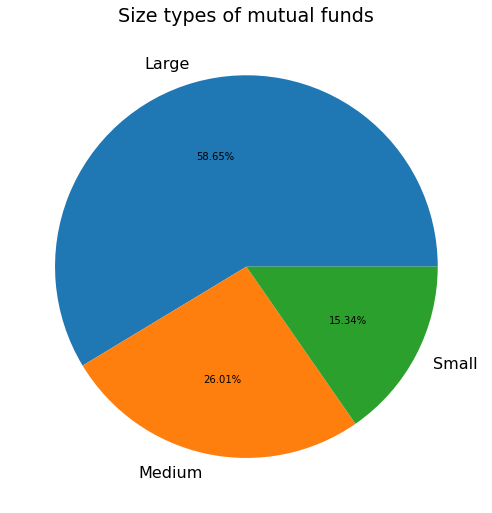

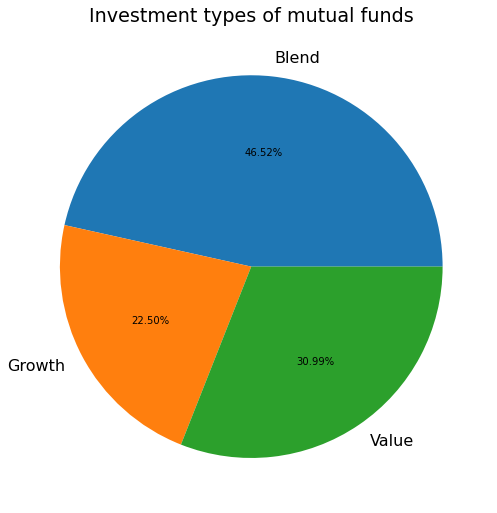

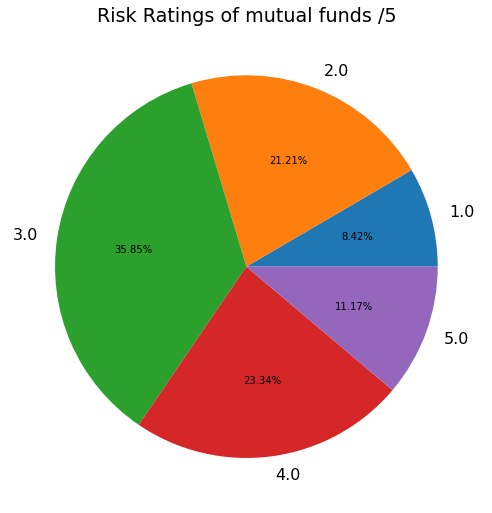

In [22]:
#Basic analysis of mutual fund distributions
plt.title('Size types of mutual funds')
pie_chart(df_mf,'size_type')
plt.title('Investment types of mutual funds')
pie_chart(df_mf,'investment_type')
plt.title('Risk Ratings of mutual funds /5')
pie_chart(df_mf,'risk_rating')


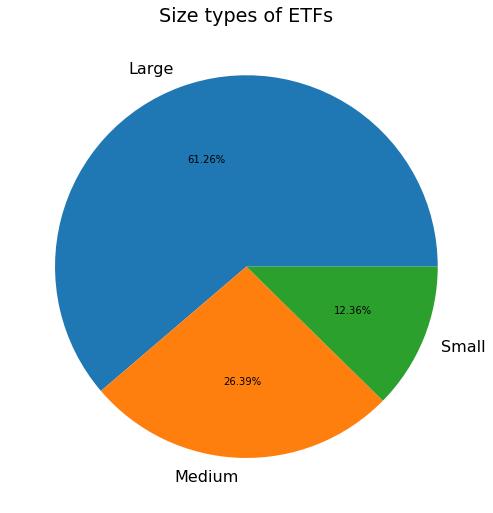

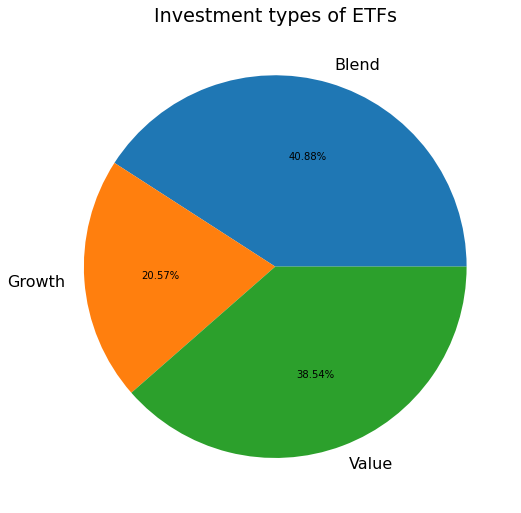

In [23]:
#Basic analysis of ETF distributions
plt.title('Size types of ETFs')
pie_chart(df_etf,'size_type')
plt.title('Investment types of ETFs')
pie_chart(df_etf,'investment_type')



In [24]:
df_mf_asset.head()

,fund_symbol,asset_cash,asset_stocks,asset_bonds,asset_others,asset_preferred,asset_convertable,net_asset_value
0,AAAAX,1.88,63.87,15.31,18.95,0.00,0.00,6.979100e+08
1,AAADX,3.49,48.14,48.37,0.00,0.00,0.00,8.938000e+07
2,AAAGX,1.54,98.46,0.00,0.00,0.00,0.00,1.490000e+09
3,AAAIX,2.75,78.52,18.48,0.01,0.07,0.14,7.072500e+08
4,AAANX,1.54,98.45,0.00,0.01,0.00,0.00,4.955100e+08


In [25]:
#creats a pie chart representing the % composition of a certain range of values in a dataset.
def percent_comp_bar(df,cols,keyword):
    """
    Creates a pie chart for a given DataFrame subset. Each section in the pie chart
    represents a column mean within the dataframe, which corresponds to a % invested
    in a given category (sector/asset)
    
    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
    """
    col_names=[]
    other=0
    col_sums=[]
    for column in cols:
        col_sum=df[column].mean()
        if(col_sum<1 or 'other' in column):
            other+=col_sum
        else:
            col_names.append(column.replace(keyword,''))
            col_sums.append(df[column].mean())
    if(other>0.1):
        col_names.append('other')
        col_sums.append(other)
    plt.pie(col_sums,labels=col_names,autopct='%.2f%%') 
    plt.show()


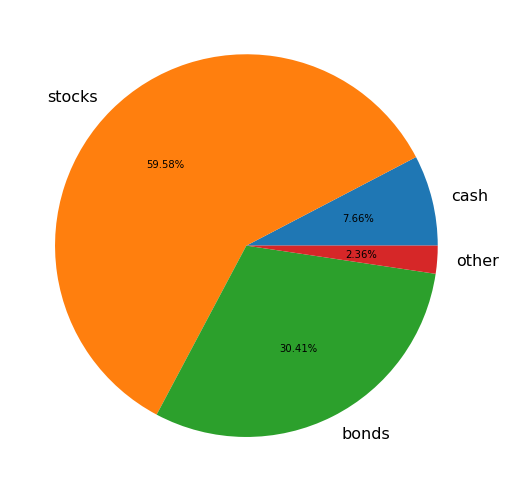

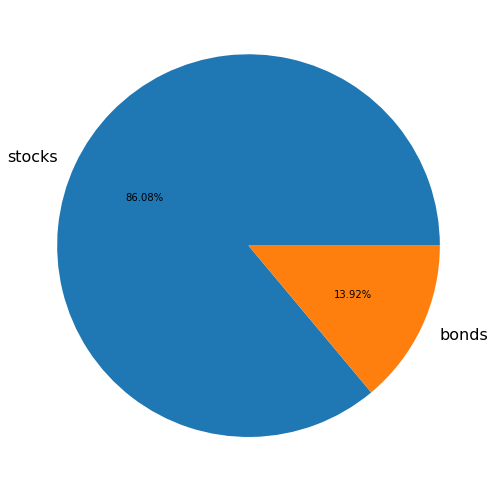

In [26]:
cols=[i for i in df_mf_asset.columns[1:7]]
percent_comp_bar(df_mf_asset,cols,'asset_')
cols=[i for i in df_etf_asset.columns[1:3]]
percent_comp_bar(df_etf_asset,cols,'asset_')

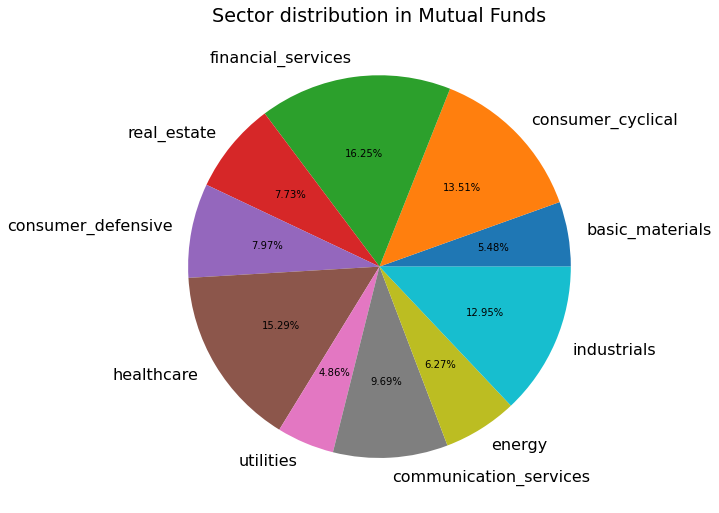

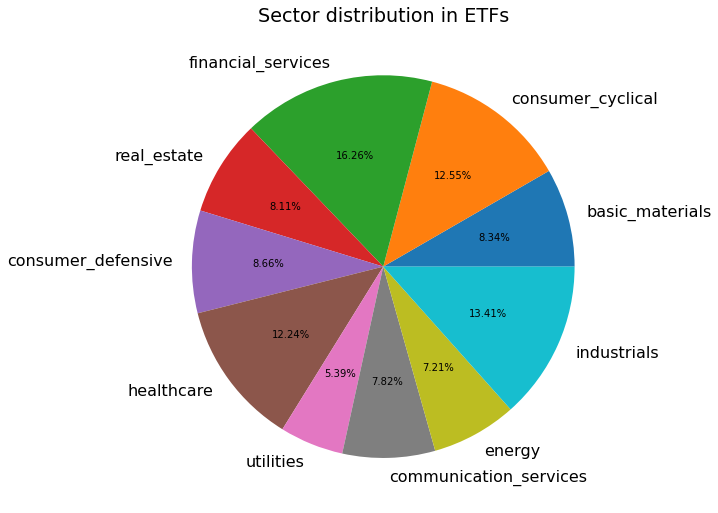

In [27]:
# Percentage invested in each sector
cols=[i for i in df_mf_sector.columns[1:11]]
plt.title('Sector distribution in Mutual Funds')
percent_comp_bar(df_mf_sector,cols,'sector_')
print('\n')
plt.title('Sector distribution in ETFs')
percent_comp_bar(df_etf_sector,cols,'sector_')


In [28]:
df_mf_asset.head()

,fund_symbol,asset_cash,asset_stocks,asset_bonds,asset_others,asset_preferred,asset_convertable,net_asset_value
0,AAAAX,1.88,63.87,15.31,18.95,0.00,0.00,6.979100e+08
1,AAADX,3.49,48.14,48.37,0.00,0.00,0.00,8.938000e+07
2,AAAGX,1.54,98.46,0.00,0.00,0.00,0.00,1.490000e+09
3,AAAIX,2.75,78.52,18.48,0.01,0.07,0.14,7.072500e+08
4,AAANX,1.54,98.45,0.00,0.01,0.00,0.00,4.955100e+08


In [29]:
df_etf_asset.head()

,fund_symbol,asset_stocks,asset_bonds,net_asset_value
0,1305,100.00,0.0,4.010000e+12
1,1306,99.99,0.0,8.430000e+12
2,1308,99.08,0.0,3.730000e+12
3,1310,100.00,0.0,1.920000e+09
4,1311,99.90,0.0,3.260000e+09


In [30]:
df_mf_return_history.columns

Index(['fund_symbol', 'fund_return_ytd', 'fund_return_1month',
       'fund_return_3months', 'fund_return_1year', 'fund_return_3years',
       'fund_return_5years', 'fund_return_10years', 'fund_return_2019',
       'fund_return_2018', 'fund_return_2017', 'fund_return_2016',
       'fund_return_2015', 'fund_return_2014', 'fund_return_2013',
       'fund_return_2012', 'fund_return_2011', 'fund_return_2010',
       'fund_return_2020_q3', 'fund_return_2020_q2', 'fund_return_2020_q1',
       'fund_return_2019_q4', 'fund_return_2019_q3', 'fund_return_2019_q2',
       'fund_return_2019_q1', 'fund_return_2018_q4', 'fund_return_2018_q3',
       'fund_return_2018_q2', 'fund_return_2018_q1', 'fund_return_2017_q4',
       'fund_return_2017_q3', 'fund_return_2017_q2', 'fund_return_2017_q1',
       'fund_return_2016_q4', 'fund_return_2016_q3', 'fund_return_2016_q2',
       'fund_return_2016_q1', 'fund_return_2015_q4', 'fund_return_2015_q3',
       'fund_return_2015_q2', 'fund_return_2015_q1', 'fund_

In [31]:
#Creates a bar plot of the 20 most common values in the given column
def distribution_by_category(df):
    '''
    Param df: dataframe of funds
    
    '''
    cat_count=df['category'].value_counts()[:20]
    sns.barplot(x=cat_count.values,y=cat_count.index)
    plt.title('Distribution by Category')
    plt.tight_layout
    plt.show()

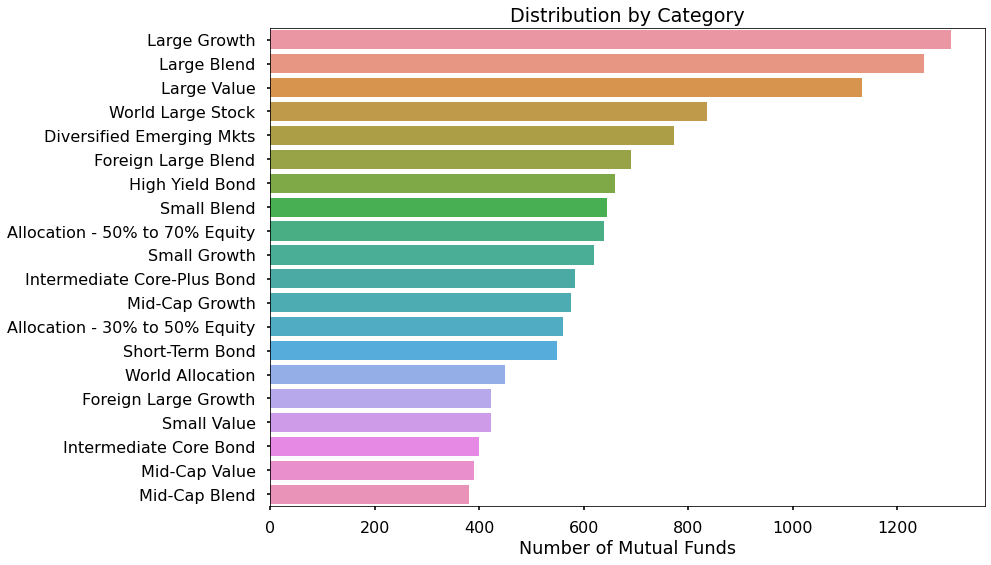

In [32]:
plt.xlabel('Number of Mutual Funds')
distribution_by_category(df_mf)

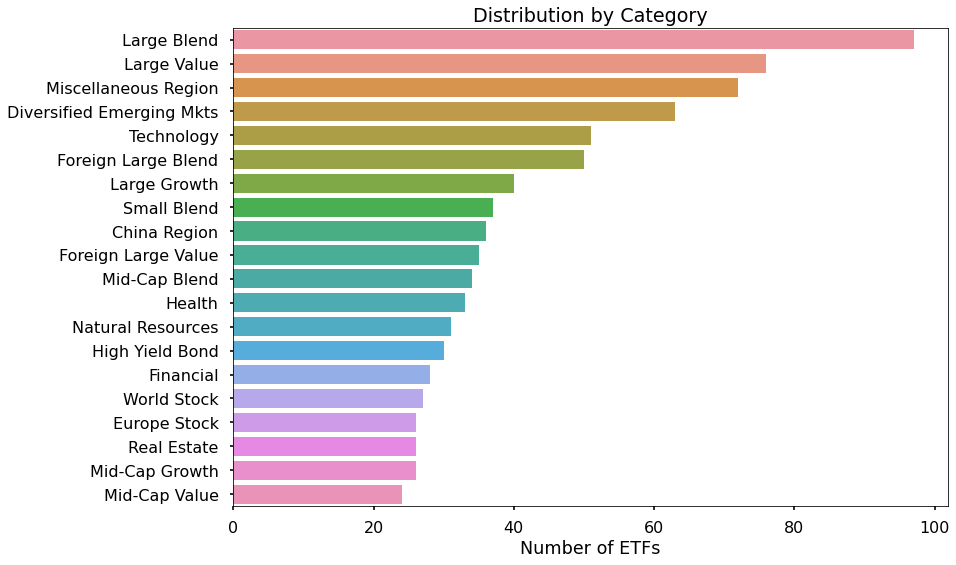

In [33]:
plt.xlabel('Number of ETFs')
distribution_by_category(df_etf)

In [34]:
#Draws a boxplot representing the dependent column as a function of the independent column
def dep_by_indep_boxplot(df_joined,independent,dependent):
    colors=['blue','grey','magenta','yellow','cyan','orange']
    print('Distribution of {} according to {}'.format(dependent,independent)+'\n')
    criteria=[i for i in df_joined[independent].sort_values(ascending=True).dropna().unique()]
    col_count=len(criteria)
    table=df_joined.melt(id_vars=[independent],value_vars=[dependent]).dropna()
    
    fig,ax=plt.subplots(nrows=1,ncols=col_count,figsize=(15,9))
    for i in range(0,col_count):
        sns.boxplot(data=table.where(table[independent]==criteria[i]).value,ax=ax[i],color=colors[i])
        ax[i].set_title(independent + ' = ' + str(criteria[i]))
        plt.tight_layout()
    


Distribution of price_earnings_ratio according to risk_rating



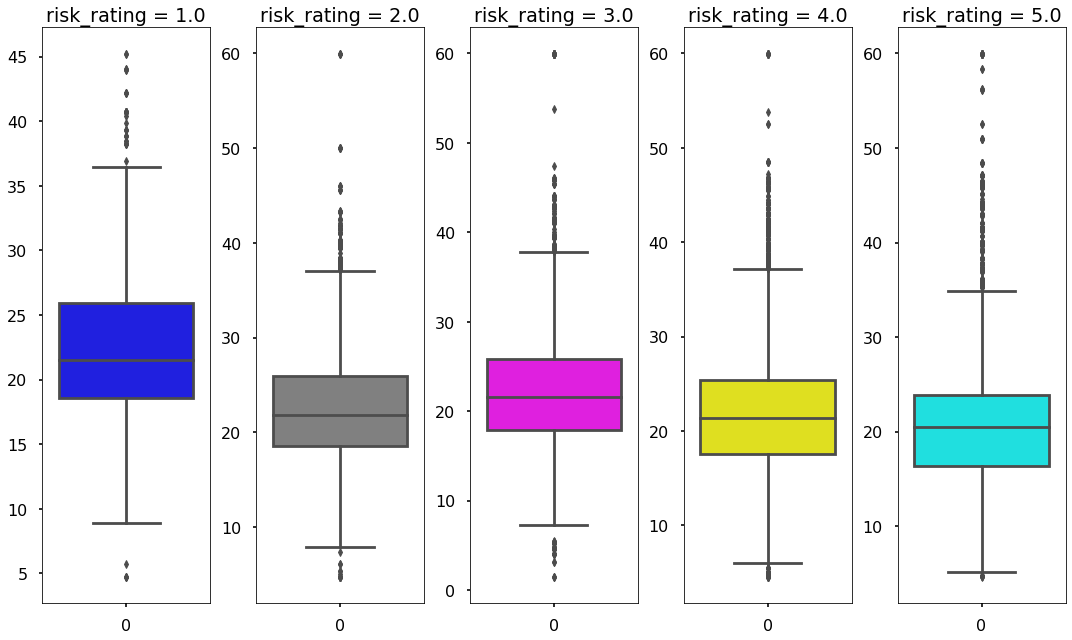

In [35]:
joined=pd.merge(df_mf,df_mf_ratios)
dep_by_indep_boxplot(joined,'risk_rating','price_earnings_ratio')

Distribution of fund_alpha_3years according to size_type



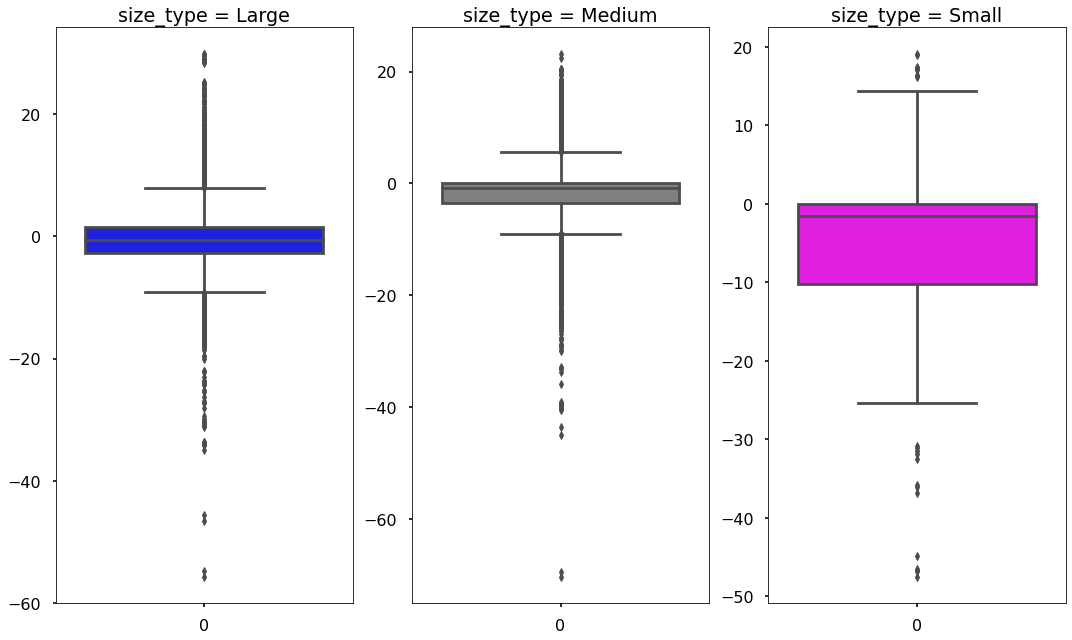

In [36]:
joined=pd.merge(df_mf,df_mf_stats)
dep_by_indep_boxplot(joined,'size_type','fund_alpha_3years')

In [37]:
df_mf_return_history.columns

Index(['fund_symbol', 'fund_return_ytd', 'fund_return_1month',
       'fund_return_3months', 'fund_return_1year', 'fund_return_3years',
       'fund_return_5years', 'fund_return_10years', 'fund_return_2019',
       'fund_return_2018', 'fund_return_2017', 'fund_return_2016',
       'fund_return_2015', 'fund_return_2014', 'fund_return_2013',
       'fund_return_2012', 'fund_return_2011', 'fund_return_2010',
       'fund_return_2020_q3', 'fund_return_2020_q2', 'fund_return_2020_q1',
       'fund_return_2019_q4', 'fund_return_2019_q3', 'fund_return_2019_q2',
       'fund_return_2019_q1', 'fund_return_2018_q4', 'fund_return_2018_q3',
       'fund_return_2018_q2', 'fund_return_2018_q1', 'fund_return_2017_q4',
       'fund_return_2017_q3', 'fund_return_2017_q2', 'fund_return_2017_q1',
       'fund_return_2016_q4', 'fund_return_2016_q3', 'fund_return_2016_q2',
       'fund_return_2016_q1', 'fund_return_2015_q4', 'fund_return_2015_q3',
       'fund_return_2015_q2', 'fund_return_2015_q1', 'fund_

In [38]:
df_mf_asset.columns

Index(['fund_symbol', 'asset_cash', 'asset_stocks', 'asset_bonds',
       'asset_others', 'asset_preferred', 'asset_convertable',
       'net_asset_value'],
      dtype='object')

In [39]:
df_mf_ratios.columns

Index(['fund_symbol', 'fund_net_annual_expense_ratio', 'price_earnings_ratio',
       'price_book_ratio', 'price_sales_ratio', 'price_cashflow_ratio',
       'fund_sharpe_ratio_3years', 'fund_sharpe_ratio_5years',
       'fund_sharpe_ratio_10years', 'fund_treynor_ratio_3years',
       'fund_treynor_ratio_5years', 'fund_treynor_ratio_10years'],
      dtype='object')

# __DATA LIMITATIONS__:

The two main limitations of our data set that have been noticed are: 
1. Missing information within specific columns of the dataset. For example the column 'median_market_cap' in the ETF dataframe contains lots of values of 0.0 . This makes analysis of median market cap more difficult - how do we deal with these zero values? Excluding these values of 0.0 might introduce bias into our analysis. The ETFs that have median market caps of 0.0 might share a common trait that is no longer being factored into the analysis if we were to remove all these ETfs.

2. The data of ETfs and Mfs are contained in separate CSV files. There is no obvious way for us to merge this data into a single CSV file. If we were to merge these CSV files the resulting CSV file would not be very readable. 

# __QUESTIONS FOR REVIEWRS__: